In [1]:
from __future__ import absolute_import, division, print_function

import sys
import skimage.io
import numpy as np
import tensorflow as tf
import json
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../')

from models import vgg_net, lstm_net, processing_tools
from util.cnn import fc_layer as fc
from util.cnn import fc_relu_layer as fc_relu
from util import im_processing, text_processing, eval_tools

print("Libraries loaded.")

C:\Users\Yannis\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Libraries loaded.


In [5]:
# Parameters
vocab_file = '../exp-referit/data/vocabulary_referit.txt'
pretrained_model = '../exp-referit/tfmodel/model_crop.tfmodel'

# Model Params
T = 20
N = 1
num_vocab = 8803
embed_dim = 1000
lstm_dim = 1000
mlp_hidden_dims = 500
input_H = 224
input_W = 224

D_im = 1000
D_text = lstm_dim

neg_iou = 1e-6

print("Parameters initialized.")

Parameters initialized.


In [3]:
# Inputs
text_seq_batch = tf.placeholder(tf.int32, [T, N])
imcrop_batch = tf.placeholder(tf.float32, [N, 224, 224, 3])
lstm_top_batch = tf.placeholder(tf.float32, [N, D_text])
fc8_crop_batch = tf.placeholder(tf.float32, [N, D_im])

# Language feature (LSTM hidden state)
lstm_top = lstm_net.lstm_net(text_seq_batch, num_vocab, embed_dim, lstm_dim)

# Local image feature
fc8_crop = vgg_net.vgg_fc8(imcrop_batch, 'vgg_local', apply_dropout=False)

# L2-normalize the features (except for spatial_batch)
# and concatenate them along axis 1 (feature dimension)
feat_all = tf.concat(axis=1, values=[tf.nn.l2_normalize(lstm_top_batch, 1),
                         tf.nn.l2_normalize(fc8_crop_batch, 1)])

# Outputs
# MLP Classifier over concatenate feature
with tf.variable_scope('classifier'):
    mlp_l1 = fc_relu('mlp_l1', feat_all, output_dim=mlp_hidden_dims)
    mlp_l2 = fc('mlp_l2', mlp_l1, output_dim=1)
scores = mlp_l2

# Load pretrained model
snapshot_restorer = tf.train.Saver(None)
sess = tf.Session()
snapshot_restorer.restore(sess, pretrained_model)

# Load vocabulary
vocab_dict = text_processing.load_vocab_dict_from_file(vocab_file)

print("Done")

INFO:tensorflow:Restoring parameters from ../exp-referit/tfmodel/model_crop.tfmodel
Done


In [37]:
# input image and query
im_file = './demo_data/38100.jpg'
query = "green dog walking on a banana"

# Pre-allocate arrays
imcrop_val = np.zeros((N, input_H, input_W, 3), dtype=np.float32)
text_seq_val = np.zeros((T, N), dtype=np.int32)
lstm_top_val = np.zeros((N, D_text))

# Preprocess image and text
im = skimage.io.imread(im_file)
processed_im = skimage.img_as_ubyte(im_processing.resize_and_pad(im, input_H, input_W))
imcrop_val[0, :] = processed_im.astype(np.float32) - vgg_net.channel_mean
text_seq_val[:, 0] = text_processing.preprocess_sentence(query, vocab_dict, T)

# Extract visual feature
fc8_crop_val = sess.run(fc8_crop, feed_dict={imcrop_batch:imcrop_val})

# Extract language feature
lstm_top_val[...] = sess.run(lstm_top, feed_dict={text_seq_batch:text_seq_val})

# Compute scores per proposal
scores_val = sess.run(scores,
    feed_dict={
        lstm_top_batch:lstm_top_val,
        fc8_crop_batch:fc8_crop_val
    })
scores_val = np.squeeze(scores_val)

# Final prediction
prediction = scores_val > 0

print("Done")

C:\Users\Yannis\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Yannis\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Done


True 6.0348945
query text = 'green dog walking on a banana'
Done


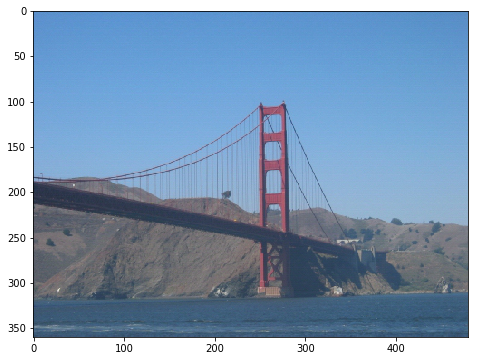

In [38]:
plt.figure(figsize=(12, 6))
plt.imshow(im)
print(prediction, scores_val)

print("query text = '%s'" % query)

print("Done")